# Statistics Based on Word Counts

## Table of Contents

* [Character List](#character_list)
* [Helper Functions](#helper_functions)
* [Complete Dialog Data of All Three Movies](#dialog_data_movies)
* [Complete Stage Directions of All Three Movies](#stage_directions_data)
* [Complete Dioalog Data of Individual Characters](#dialog_data_persons)
* [Wordclouds and Word Frequencies](#wordclouds_frequency_tables)
* [Character Mentions](#character_mentions)

In [1]:
from bs4 import BeautifulSoup
import requests
import os
from os import path
import re
import pandas as pd
import numpy as np
from textblob import TextBlob
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from matplotlib.colors import ListedColormap

## Character List <a class="anchor" id="character_list"></a>

In [2]:
# get list with all characters
characters_list = ["frodo", "gandalf", "sam", "merry", "pippin", "aragorn", "arwen", "eowyn", "legolas", "gimli", "theoden", "saruman", "gollum", "smeagol", "sauron"]

## Helper functions <a class="anchor" id="helper_functions"></a>

### Get Complete Dialog Data of a Single Movie

In [3]:
def getDialogOfFilm(dfFilm):
    film = dfFilm["SUBTITLE TEXT"]
    film_text = ""
    for text in film:
        if (not pd.isna(text)):
            film_text = f'{film_text} {text}'
            # replaces "... ..." or "..." (and variations with whitespace) with one single space character
            film_text = re.sub(r'\s?\.\.\.\s?\.?\.?\.?\s?', " ", film_text)
    return film_text

### Get Dialog Data of Specific Character

In [4]:
# takes the name of a character (exactly as spelled in the data frame) and returns all dialog of this character
def getTextOfCharacter(dfFilm, character):
    character = dfFilm[dfFilm["SPEAKER"] == character]
    character_text = ""
    for text in character["SUBTITLE TEXT"]:
        if (not pd.isna(text)):
            character_text = f'{character_text} {text}'
            # replaces "... ..." with space character
            character_text = re.sub(r'\s?\.\.\.\s?\.?\.?\.?\s?', " ", character_text)
    return character_text

### Save Dialog Data of Specific Character

In [5]:
def saveCharacterDataToFile(characterData, name):
        filename = f'{name}.txt'
        # Datei löschen, falls sie existiert:
        if os.path.exists(f'data/{filename}'):
            os.remove(f'data/{filename}')

        with open(f'data/{filename}', 'a') as f:
            f.write(characterData)
            print(f'File {filename} saved.')

### Count Words

In [6]:
def word_count(string):
    return(len(string.strip().split(" ")))

### Count Occurences of Single Word

In [7]:
def word_freq(string,word):
    string=string.lower() 
    return string.count(word)

### Count All Word Frequencies → [  Wordcloud Code](#wordclouds_frequency_tables)

In [8]:
# gets frequency of the n most used words, if no paramter set, returns frequency of all words
def get_word_frequency(text, word_number):
    # remove punctiation to standardize words (Sam?, Sam., Sam! --> Sam)
    text = re.sub(r"\.", "", text)
    text = re.sub(r"\!", "", text)
    text = re.sub(r"\?", "", text)
    text = re.sub(r"\,", "", text)
    text = re.sub(r"\'s", "", text)
    #count frequency
    frequency = dict(Counter(text.split()))
    # filter frequency list by using stopwords list from wordcloud module
    stopwords = list(STOPWORDS)
    stopwords.append("will")
    frequency_cleaned = {k: v for k, v in frequency.items() if (k not in stopwords and k.lower() not in stopwords)}
    #  sort frequency dictionary and convert it to dataframe
    frequency_sorted = sorted(frequency_cleaned.items(), key=lambda x: x[1], reverse=True)[:word_number]
    frequency_df = pd.DataFrame(frequency_sorted, columns=['Word', 'Frequency'])
    return frequency_df

### Generate Standard Wordclouds → [Wordcloud Code](#wordclouds_frequency_tables)

Wordcloud settings:

1.) built-in stopwords list is used by default

2.) max. number of words is 200

3.) no collocations

Every time the cell is run, the color and positoning of the words will be slightly different.

In [9]:
# function to generate wordcloud
def make_wordcloud(data):
    stopwords = list(STOPWORDS)
    stopwords.append("will")
    wordcloud = WordCloud(background_color = 'white', stopwords=stopwords, collocations=False, width=1920, height=1080).generate(data)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    return wordcloud

### Generate Wordclouds with Mask Layers → [Wordcloud Code](#wordclouds_frequency_tables)

In [10]:
def make_masked_wordcloud(data):
    stopwords = list(STOPWORDS)
    stopwords.append("will")
    # .jpg filetype mask since "All white (#FF or #FFFFFF) entries will be considerd “masked out” while other entries will be free to draw on." (https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#:~:text=only%20vertical%20words.)-,masknd,-%2Darray%20or%20None)
    # image source: https://w7.pngwing.com/pngs/213/632/png-transparent-the-lord-of-the-rings-the-fellowship-of-the-ring-sauron-one-ring-ring-love-ring-gold.png
    mask = np.array(Image.open("data/ring.jpg"))
    wordcloud = WordCloud(background_color="white", stopwords=stopwords, collocations=False, mask=mask, contour_color='white').generate(data)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.figure()
    plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud

### Make Dataframe of Character Mentions

In [11]:
def makeMentionsDf(data):
    # split up text into single words and lowercase them
    # word_list = data.lower().split()
    # iterate over character list and count each character in all movie data
    character_mentions = {}
    for character in characters_list:
        character_mentions[character] = data.count(character)
    #  sort character mentions dictionary and convert it to dataframe
    character_mentions_sorted = sorted(character_mentions.items(), key=lambda x: x[1], reverse=True)
    character_mentions_df = pd.DataFrame(character_mentions_sorted, columns=['Character', 'Mentions'])
    return character_mentions_df

## Complete Dialog Data of All Three Movies <a class="anchor" id="dialog_data_movies"></a>

In [12]:
# load reduced csv dialog data of script 1
df_dialog_film_1 = pd.read_csv("data/LOTR Subtitles reduced film 1.csv", sep=";")
df_dialog_film_1

ORIG ID    SPEAKER                               SUBTITLE TEXT SCENE  \
0        NaN        NaN                                         NaN   NaN   
1          2  Galadriel                       The world is changed.   NaN   
2          4  Galadriel                     I feel it in the water.   NaN   
3          6  Galadriel                     I feel it in the earth.   NaN   
4          8  Galadriel                      I smell it in the air.   NaN   
...      ...        ...                                         ...   ...   
1968    1779      Frodo  I don't suppose we'll ever see them again.   NaN   
1969    1780        Sam                      We may yet, Mr. Frodo.   NaN   
1970    1781        Sam                                     We may.   NaN   
1971    1782      Frodo                                      Sam...   NaN   
1972    1783      Frodo                 ...I'm glad you're with me.   NaN   

      ITUNES CHAPTER  
0                1.0  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
1968             NaN  
1969             NaN  
1970             NaN  
1971             NaN  
1972             NaN  

[1973 rows x 5 columns]

In [13]:
# get dialog text of film 1
film_1_text = getDialogOfFilm(df_dialog_film_1).lower()
film_1_text

" the world is changed. i feel it in the water. i feel it in the earth. i smell it in the air. much that once was  is lost. for none now live who remember it. it began with the forging of the great rings. three were given to the elves: immortal, wisest and fairest of all beings. seven to the dwarf-lords: great miners and craftsmen of the mountain halls. and nine  nine rings were gifted to the race of men  who, above all else, desire power. for within these rings was bound the strength and will to govern each race. but they were all of them deceived. for another ring was made. in the land of mordor, in the fires of mount doom  the dark lord sauron forged in secret a master ring  to control all others. and into this ring he poured his cruelty, his malice  and his will to dominate all life. one ring to rule them all. one by one  the free lands of middle-earth fell to the power of the ring. but there were some who resisted. a last alliance of men and elves marched against the armies of mor

In [14]:
# load reduced csv dialog data of script 2
df_dialog_film_2 = pd.read_csv("data/LOTR Subtitles reduced film 2.csv", sep=";")
df_dialog_film_2

ORG ID  SPEAKER                                      SUBTITLE TEXT  \
0        NaN      NaN                                                NaN   
1        1.0  Gandalf                                   You cannot pass!   
2        1.0    Frodo                                           Gandalf!   
3        2.0  Gandalf  I am a servant of the Secret Fire, wielder of ...   
4        3.0  Gandalf                             Go back to the Shadow.   
...      ...      ...                                                ...   
2191  2064.0   Gollum            And then we takes it once they're dead.   
2192  2065.0  Smeagol                                 Once they're dead.   
2193  2066.0  Smeagol             Come on, Hobbits. Long ways to go yet.   
2194  2067.0  Smeagol                     Smeagol will show you the way.   
2195  2068.0   Gollum                                         Follow me.   

      SCENE  ITUNES CHAPTER  
0       NaN             1.0  
1       NaN             NaN  
2       NaN             NaN  
3       NaN             NaN  
4       NaN             NaN  
...     ...             ...  
2191    NaN             NaN  
2192    NaN             NaN  
2193    NaN             NaN  
2194    NaN             NaN  
2195    NaN             NaN  

[2196 rows x 5 columns]

In [15]:
# get dialog text of script 2
film_2_text = getDialogOfFilm(df_dialog_film_2).lower()
film_2_text

' you cannot pass! gandalf! i am a servant of the secret fire, wielder of the flame of anor. go back to the shadow. the dark fire will not avail you, flame of udun! you shall not pass! no! no! gandalf! fly, you fools. no! gandalf! gandalf! what is it, mr. frodo? nothing. just a dream. can you see the bottom? no! don\'t look down, sam! just keep going! catch it! grab it, mr. frodo! mr. frodo! i think i\'ve found the bottom. bogs and rope, and goodness knows what. it\'s not natural. none of it. what\'s in this? nothing. just a bit of seasoning. i thought maybe if we was having a roast chicken one night or something. roast chicken?! you never know. sam. my dear sam. it\'s very special, that. it\'s the best salt in all the shire. it is special. it\'s a little bit of home. we can\'t leave this here for someone to follow us down. who\'s gonna follow us down here, mr. frodo? it\'s a shame, really. lady galadriel gave me that. real elvish rope. well, there\'s nothing for it. it\'s one of my kn

In [16]:
# load reduced csv dialog data of script 3
df_dialog_film_3 = pd.read_csv("data/LOTR Subtitles reduced film 3.csv", sep=";")
df_dialog_film_3

ORG ID  SPEAKER                                      SUBTITLE TEXT  \
0        NaN      NaN                                                NaN   
1        1.0   Deagol                                           Sméagol!   
2        2.0   Deagol                                      I've got one!   
3        3.0   Deagol                   I've got a fish, Smeag. Smeagol!   
4        4.0  Smeagol       Pull it in. Go on. Go on. Go on. Pull it in.   
...      ...      ...                                                ...   
1871  1811.0    Frodo  You will have to be one and whole for many years.   
1872  1812.0    Frodo     You have so much to enjoy and to be and to do.   
1873  1813.0    Frodo                 Your part in the story will go on.   
1874  1814.0      Sam                                            Well...   
1875  1815.0      Sam                                          I'm back.   

      SCENE  ITUNES CHAPTER  
0       NaN             1.0  
1       NaN             NaN  
2       NaN             NaN  
3       NaN             NaN  
4       NaN             NaN  
...     ...             ...  
1871    NaN             NaN  
1872    NaN             NaN  
1873    NaN             NaN  
1874    NaN             NaN  
1875    NaN             NaN  

[1876 rows x 5 columns]

In [17]:
# get dialog text of script 3
film_3_text = getDialogOfFilm(df_dialog_film_3).lower()
film_3_text

' sméagol! i\'ve got one! i\'ve got a fish, smeag. smeagol! pull it in. go on. go on. go on. pull it in. deagol! deagol? deagol. give us that, deagol, my love. why? because  it\'s my birthday and i wants it. my precious. they cursed us. murderer. “murderer” they called us. they cursed us and drove us away. gollum. gollum. gollum. and we wept, precious. we wept to be so alone. and cool so nice for feet and we only wish to catch a fish so juicy sweet and we forgot the taste of bread  the sound of trees  the softness of the wind. we even forgot our own name. my precious. wake up! wake up! wake up, sleepies. we must go, yes. we must go at once. haven\'t you had any sleep, mr. frodo? i\'ve gone and had too much. must be getting late. no. it isn\'t. it isn\'t midday yet. the days are growing darker. come on! must go! no time! not before mr. frodo\'s had something to eat. no time to lose, silly. here. what about you? oh, no, i\'m not hungry. leastways, not for lembas bread. sam. all right. we

In [18]:
# concat dialog text from all three movies
dialog_text_all_films = f'{film_1_text}{film_2_text}{film_3_text}'
dialog_text_all_films

' the world is changed. i feel it in the water. i feel it in the earth. i smell it in the air. much that once was  is lost. for none now live who remember it. it began with the forging of the great rings. three were given to the elves: immortal, wisest and fairest of all beings. seven to the dwarf-lords: great miners and craftsmen of the mountain halls. and nine  nine rings were gifted to the race of men  who, above all else, desire power. for within these rings was bound the strength and will to govern each race. but they were all of them deceived. for another ring was made. in the land of mordor, in the fires of mount doom  the dark lord sauron forged in secret a master ring  to control all others. and into this ring he poured his cruelty, his malice  and his will to dominate all life. one ring to rule them all. one by one  the free lands of middle-earth fell to the power of the ring. but there were some who resisted. a last alliance of men and elves marched against the armies of mor

## Complete Stage Directions of All Three Movies<a class="anchor" id="stage_directions_data"></a>

In [19]:
# load stage directions data of script 1
df_stage_directions_1 = ""
with open("data/lotr_skript_1_regie.txt", "r") as f:
    df_stage_directions_1 = f.read().lower()
df_stage_directions_1

'black continues elvish singing a woman\'s voice is whispering, tinged with sadness and regret flickering firelight. the noldorin forge in eregion. molten gold pours from the lip of an iron ladle. three rings, each set with a single gem, are received by the high elves-galadriel, gil-galad and cirdan. seven rings held aloft in triumph by the dwarf lords. nine rings clutched tightly by the kings of men as if holding-close a precious secret. an ancient parchment map of middle earth moving slowly across the map as if drawn by an unseen force the camera closes in on a place name mordor. sauron forging the one ring in the chambers of sammath naur. the one ring falls through space and into flames. a great shadow falls across the map closing in around the realm of gondor. screaming villagers, men, women, and children, run from their homes, pursued by armies of hideous orcs. the battle of dagorlad the elf lord, elrond, commands rank after rank of elven archers orcs retreating before the army of

In [20]:
# load stage directions data of script 2
df_stage_directions_2 = ""
with open("data/lotr_skript_2_regie.txt", "r") as f:
    df_stage_directions_2 = f.read().lower()
df_stage_directions_2

"camera zooms in through the mountain and focuses on gandalf and the balrog on the bridge of khazad-dum. the balrog strikes down on gandalf with its flaming sword. gandalf parries the blow with glamdring, shattering the balrog's sword. gandalf strikes his staff onto the bridge. as the balrog steps forward, the bridge collapses from under it and the demon plunges backward into the chasm. gandalf, exhausted, leans on his staff and watches the balrog fall then turns to follow the others. at the last minute, the flaming whip lashes up from the depths of the abyss and winds around gandalf's ankle, dragging him over the edge. he clings onto the bridge but is straining to keep his grip. frodo rushes forward but boromir restrains him. gandalf loses his grip and falls into the chasm gandalf loses his grip and falls into the chasm calls after gandalf as he falls into the abyss gandalf falls after the balrog and grabs hold of his sword glamdring on his way down. as they continue to plunge into th

In [21]:
# load stage directions data of script 3
df_stage_directions_3 = ""
with open("data/lotr_skript_3_regie.txt", "r") as f:
    df_stage_directions_3 = f.read().lower()
df_stage_directions_3

'smeagol and his cousin, deagol, sit in a small coracle, their fishing lines draped over the side sunshine glinting off the surface of the water. an idyllic image. suddenly deagol\'s fishing rod bends under the weight of a large fish. deagol pulls on his rod, but is hauled overboard and disappears underwater with a splash. smeagol leaning over the boat concerned. deagol is towed to the river bed by a large fish he suddenly lets go of the line eyes fixed on a shining gold ring, lying in \'the silt. deagol climbs out of the water, onto the river bank. the ring revealed in deagol\'s palm. smeagol peers over his shoulder the gold reflects in smeagol\'s eyes. the hum of the ring growing louder. deagol turns to look at him, a smirk on his face. smeagol moves towards deagol. smeagol jumps on deagol strangling him. smeagol rips the glittering ring from deagol\'s limp hand. smeagol slips the ring onto his finger and disappears. smeagol descending into madness. his body twists and distorts he be

In [22]:
# concat stage directions text from all three movies
stage_directions_all_films = f'{df_stage_directions_1}{df_stage_directions_2}{df_stage_directions_3}'
stage_directions_all_films

'black continues elvish singing a woman\'s voice is whispering, tinged with sadness and regret flickering firelight. the noldorin forge in eregion. molten gold pours from the lip of an iron ladle. three rings, each set with a single gem, are received by the high elves-galadriel, gil-galad and cirdan. seven rings held aloft in triumph by the dwarf lords. nine rings clutched tightly by the kings of men as if holding-close a precious secret. an ancient parchment map of middle earth moving slowly across the map as if drawn by an unseen force the camera closes in on a place name mordor. sauron forging the one ring in the chambers of sammath naur. the one ring falls through space and into flames. a great shadow falls across the map closing in around the realm of gondor. screaming villagers, men, women, and children, run from their homes, pursued by armies of hideous orcs. the battle of dagorlad the elf lord, elrond, commands rank after rank of elven archers orcs retreating before the army of

## Dialog Data of Individual Characters <a class="anchor" id="dialog_data_persons"></a>

### Dialog Data - Frodo <a class="anchor" id="dialog_data_frodo"></a>

In [23]:
# Frodo's dialog text - Film 1
frodo_1 = getTextOfCharacter(df_dialog_film_1, "Frodo").lower()
#frodo_1

In [24]:
# Frodo's dialog text - Film 2
frodo_2 = getTextOfCharacter(df_dialog_film_2, "Frodo").lower()
#frodo_2

In [25]:
# Frodo's dialog text - Film 3
frodo_3 = getTextOfCharacter(df_dialog_film_3, "Frodo").lower()
#frodo_3

In [26]:
# Frodo's dialog text - all films
frodo_all = f'{frodo_1} {frodo_2} {frodo_3}'
frodo_all

" you're late. it's wonderful to see you, gandalf! you know bilbo. he's got the whole piece in an uproar. half the shire's been invited. and the rest of them are turning up anyway. to tell you the truth, bilbo's been a bit odd lateiy. i mean, more than usual. he's taken to locking himself in his study. he spends hours and hours poring over old maps when he thinks i'm not looking. he's up to something. all right, then. keep your secrets. but i know you have something to do with it. before you came along, we bagginses were very well thought of. never had any adventures or did anything unexpected. whatever you did, you've been officially labeled a disturber of the peace. gandalf? i'm glad you're back. go on, sam. ask rosie for a dance. oh, no, you don't. go on! bilbo? bilbo, have you been at the gaffer's home brew? bilbo. bilbo, watch out for the dragon! speech! bilbo! bilbo! he's gone, hasn't he? he talked for so long about leaving  i didn't think he'd really do it. gandalf? where are yo

### Dialog Data - Gandalf <a class="anchor" id="dialog_data_gandalf"></a>

In [27]:
# Gandalf's dialog text - film 1
gandalf_1 = getTextOfCharacter(df_dialog_film_1, "Gandalf").lower()
#gandalf_1

In [28]:
# Gandalf's dialog text - film 2
gandalf_2 = getTextOfCharacter(df_dialog_film_2, "Gandalf").lower()
#gandalf_2

In [29]:
# Gandalf's dialog text - film 3
gandalf_3 = getTextOfCharacter(df_dialog_film_3, "Gandalf").lower()
#gandalf_3

In [30]:
# Gandalfs's dialog text - all films
gandalf_all = f'{gandalf_1} {gandalf_2} {gandalf_3}'
gandalf_all

" down from the door where it began and i must follow if i can the road goes ever on and on down from the door where it began now far ahead the road has gone and i must follow if i can a wizard is never late, frodo baggins. nor is he early. he arrives precisely when he means to. you didn't think i'd miss your uncle bilbo's birthday? so how is the old rascal? i hear it's going to be a party of special magnificence. well, that should please him. what? good gracious me. indeed. if you're referring to the incident with the dragon. i was barely involved. all i did was give your uncle a little nudge out of the door. oh, really? so am i, dear boy. so am i. whoa, whoa. and what about very old friends? bilbo baggins. good to see you. 111 years old! who would believe it? you haven't aged a day. just tea, thank you. just tea, thank you. no, not at all. so you mean to go through with your plan? frodo suspects something. you will tell him, won't you? he's very fond of you. whoa up they go! meriadoc

### Dialog Data - Sam <a class="anchor" id="dialog_data_sam"></a>

In [31]:
# Sams's dialog text - film 1
sam_1 = getTextOfCharacter(df_dialog_film_1, "Sam").lower()
#sam_1

In [32]:
# Sams's dialog text - film 2
sam_2 = getTextOfCharacter(df_dialog_film_2, "Sam").lower()
#sam_2

In [33]:
# Sams's dialog text - film 3
sam_3 = getTextOfCharacter(df_dialog_film_3, "Sam").lower()
#sam_3

In [34]:
# Sams's dialog text - all films
sam_all = f'{sam_1} {sam_2} {sam_3}'
sam_all

' i think i\'ll just have another ale. good night. mind who you\'re sweet-taking. does she? good night, mr. frodo. i haven\'t been dropping no eaves. honest. i was just cutting the grass under the window there if you follow me. i heard raisedices. nothing important. that is, i heard a good deal about a ring, and a dark lord  and something about the end of the world but  please, mr. gandalf, sir, don\'t hurt me. don\'t turn me into anything unnatural. this is it. if i take one more step  it\'ll be the farthest away from home i\'ve ever been. they\'re leaving middle-earth. i don\'t know why  it makes me sad. everywhere i lie there\'s a dirty great root sticking into my back. it\'s not working, mr. frodo. i\'m never going to be able to sleep out here. mr. frodo? frodo? frodo! i thought i\'d lost you. it\'s just something gandalf said. “don\'t you lose him, samwise gamgee.” and i don\'t mean to. get off him. come on, frodo. you\'ve been into farmer maggot\'s crop! trust a brandybuck and a 

### Dialog Data - Merry <a class="anchor" id="dialog_data_merry"></a>

In [35]:
# Merry's dialog text - film 1
merry_1 = getTextOfCharacter(df_dialog_film_1, "Merry").lower()
#merry_1

In [36]:
# Merry's dialog text - film 2
merry_2 = getTextOfCharacter(df_dialog_film_2, "Merry").lower()
#merry_2

In [37]:
# Merry's dialog text - film 3
merry_3 = getTextOfCharacter(df_dialog_film_3, "Merry").lower()
#merry_3

In [38]:
# Merry's dialog text - all films
merry_all = f'{merry_1} {merry_2} {merry_3}'
merry_all

" quickly. no no, the big one — big one you're supposed to stick it in the ground. outside! that was good. hello, frodo. i don't know why he's so upset. it's only a couple of carrots. yes, pippin. my point is  he's clearly overreacting. run! i think i've broken something. what? that was just a detour. a short cut. here's a nice one, sam. what was that? that black rider was looking for something. or someone. frodo? right. bucklebury ferry. follow me. run! this way! follow me! run! get the rope, sam! the brandywine bridge. 20 miles. this, my friend, is a pint. how can we know this strider is a friend of gandalf? he's foul enough. don't think he knows about second breakfast, pip. i wouldn't count on it. pippin! what do they eat when they can't get hobbit? my tomato's burst. want a tomato, sam? tomatoes, sausages, nice crispy bacon. they're close. who is she? where are you taking him? oy. we're coming too! you'll have to send us home tied up in a sack to stop us. well, that rules you out, 

### Dialog Data - Pippin  <a class="anchor" id="dialog_data_pippin"></a>

In [39]:
# Pippin's dialog text - film 1
pippin_1 = getTextOfCharacter(df_dialog_film_1, "Pippin").lower()
#pippin_1

In [40]:
# Pippin's dialog text - film 2
pippin_2 = getTextOfCharacter(df_dialog_film_2, "Pippin").lower()
#pippin_2

In [41]:
# Pippin's dialog text - film 3
pippin_3 = getTextOfCharacter(df_dialog_film_3, "Pippin").lower()
#pippin_3

In [42]:
# Pippin's dialog text - all films
pippin_all = f'{pippin_1} {pippin_2} {pippin_3}'
pippin_all

' done! it is in the ground. this was your idea. let\'s get another one. is a mug of beer inside this took!” frodo. merry, it\'s frodo baggins. and some cabbages. and those three bags of potatoes that we lifted last week. and then the mushrooms the week before. oh, that was close. mushrooms! that\'s mine. that\'s nice, merry. what is going on? run, frodo! hurry! jump! what\'s that? it comes in pints? i\'m getting one. baggins? sure, i know a baggins. he\'s over there. frodo baggins. he\'s my second cousin, once removed on his mother\'s side  and my third cousin, twice removed  steady on, frodo. what about breakfast? we\'ve had one, yes. what about second breakfast? what about elevenses? luncheon? afternoon tea? dinner? supper? he knows about them, doesn\'t he? could i have some bacon? that\'s nice! ash on my tomatoes! is he going to die? what are they saying? anyway, you need people of intelligence on this sort of  mission. quest. thing. great! where are we going? thanks. hold him. hol

### Dialog Data - Aragorn <a class="anchor" id="dialog_data_aragorn"></a>

In [43]:
# Aragorn's dialog text - film 1
aragorn_1 = getTextOfCharacter(df_dialog_film_1, "Aragorn").lower()
#aragorn_1

In [44]:
# Strider's dialog text - film 1
strider_1 = getTextOfCharacter(df_dialog_film_1, "Strider").lower()
#strider_1

In [45]:
# Aragorn's dialog text - film 2
aragorn_2 = getTextOfCharacter(df_dialog_film_2, "Aragorn").lower()
#aragorn_2

In [46]:
# Aragorn's dialog text - film 3
aragorn_3 = getTextOfCharacter(df_dialog_film_3, "Aragorn").lower()
#aragorn_3

In [47]:
# Aragorn's dialog text - all films
aragorn_all = f'{strider_1} {aragorn_1} {aragorn_2} {aragorn_3}'
aragorn_all

" you draw far too much attention to yourself, “mr. underhill.” a little more caution from you. that is no trinket you carry. indeed. i can avoid being seen if i wish  but to disappear entirely, that is a rare gift. are you frightened? not nearly frightened enough. i know what hunts you. you have a stout heart, little hobbit. but that will not save you. you can no longer wait for the wizard, frodo. they're coming. they were once men. great kings of men. then sauron the deceiver gave to them nine rings of power. blinded by their greed, they took them without question. one by one, falling into darkness. now they are slaves to his will. they are the nazgã»l. ringwraiths. neither living nor dead. at all times they feel  the presence of the ring  drawn to the power of the one. they will never stop hunting you. into the wild. to rivendell, master gamgee. to the house of elrond. gentlemen, we do not stop till nightfall. you've already had it. tinúviel the elven-fair. immortal maiden elven-wis

### Dialog Data - Legolas <a class="anchor" id="dialog_data_legolas"></a>

In [48]:
# Legolas dialog text - film 1
legolas_1 = getTextOfCharacter(df_dialog_film_1, "Legolas").lower()
#legolas_1

In [49]:
# Legolas dialog text - film 2
legolas_2 = getTextOfCharacter(df_dialog_film_2, "Legolas").lower()
#legolas_2

In [50]:
# Legolas dialog text - film 3
legolas_3 = getTextOfCharacter(df_dialog_film_3, "Legolas").lower()
#legolas_3

In [51]:
# Legolas dialog text - all films
legolas_all = f'{legolas_1} {legolas_2} {legolas_3}'
legolas_all

" this is no mere ranger. he is aragorn, son of arathorn. you owe him your allegiance. and heir to the throne of gondor. have you heard nothing lord elrond has said? the ring must be destroyed. and you have my bow. crebain from dunland! there is a fellice on the air. why doesn't that surprise me? goblins. we must move on. we cannot linger. orcs. gandalf! come on! our fellowship stands in your debt,… haldir of lórien. he was taken by both shadow and flame. a balrog of morgoth. for we went needlessly into the net of moria. a lament for gandalf. i have not the heart to tell you. for me, the grief is still too near. lembas. elvish waybread. one small bite is enough to fill the stomach of a grown man. what was her gift? we should leave now. it is not the eastern shore that worries me. a shadow and a threat has been growing in my mind. something draws near. i can feel it. aragorn, go! the horn of gondor. hurry! frodo and sam have reached the eastern shore. you mean not to follow them.  come 

### Dialog Data - Gimli <a class="anchor" id="dialog_data_gimli"></a>

In [52]:
# Gimli's dialog text - film 1
gimli_1 = getTextOfCharacter(df_dialog_film_1, "Gimli").lower()
#gimli_1

In [53]:
# Gimli's dialog text - film 2
gimli_2 = getTextOfCharacter(df_dialog_film_2, "Gimli").lower()
#gimli_2

In [54]:
# Gimli's dialog text - film 3
gimli_3 = getTextOfCharacter(df_dialog_film_3, "Gimli").lower()
#gimli_3

In [55]:
# Gimli's dialog text - all films
gimli_all = f'{gimli_1} {gimli_2} {gimli_3}'
gimli_all

" then what are we waiting for? and i suppose you think you are the one to do it! i will be dead before i see the ring in the hands of an elf! never trust an elf! and my ax. if anyone was to ask for my opinion, which i note they're not  i'd say we were taking the long way 'round. gandalf. we could pass through the mines of moria. my cousin balin would give us a royal welcome. nothing. it's just a wisp of cloud. we cannot pass over a mountain. let us go under it. let us go through the mines of moria. the walls  of moria. dwarf doors are invisible when closed. soon, master elf, you will enjoy the fabled hospitality of the dwarves. roaring fires, malt beer, ripe meat off the bone! this, my friend, is the home of my cousin balin. and they call it a mine. a mine! no  no! oh, that was a kingly gift. no! oh, no. no. let them come! there is one dwarf yet in moria who still draws breath. mithril. you are full of surprises, master baggins. nobody tosses a dwarf. not the beard! stay close, young 

### Dialog Data - Eowyn <a class="anchor" id="dialog_data_eowyn"></a>

In [56]:
# Eowyn's dialog text - film 2
eowyn_2 = getTextOfCharacter(df_dialog_film_2, "Eowyn").lower()
#eowyn_2

In [57]:
# Eowyn's dialog text - film 3
eowyn_3 = getTextOfCharacter(df_dialog_film_3, "Eowyn").lower()
#eowyn_3

In [58]:
# Eowyn's dialog text - all films
eowyn_all = f'{eowyn_2} {eowyn_3}'
eowyn_all

" theodred. your son is badly wounded, my lord. my lord, your son  he is dead. my lord? uncle? will you not go to him? will you do nothing? leave me alone, snake! your words are poison. an evil death has set forth the noble warrior  a song shall sing sorrowing minstrels. in meduseld  that he is no more  for his necessary rest. and that he is the dearest kinsman  killing took him  they had no warning. they were unarmed. now the wild men are moving through the westfold, burning as they go. rick, cot and tree. his name is brego. he was my cousin's horse. i have heard of the magic of elves  but i did not look for it in a ranger from the north. you speak as one of their own. women of this country learned long ago: those without swords can still die upon them. i fear neither death nor pain. a cage. to stay behind bars until use and old age accept them. and all chance of valor has gone beyond recall or desire. gimli. i made some stew. it isn't much, but it's hot. really? my uncle told me a st

### Dialog Data - Arwen <a class="anchor" id="dialog_data_arwen"></a>

In [59]:
# Arwen's dialog text - film 1
arwen_1 = getTextOfCharacter(df_dialog_film_1, "Arwen").lower()
#arwen_1

In [60]:
# Arwen's dialog text - film 2
arwen_2 = getTextOfCharacter(df_dialog_film_2, "Arwen").lower()
#arwen_2

In [61]:
# Arwen's dialog text - film 3
arwen_3 = getTextOfCharacter(df_dialog_film_3, "Arwen").lower()
#arwen_3

In [62]:
# Arwen's dialog text - all films
arwen_all = f'{arwen_1} {arwen_2} {arwen_3}'
arwen_all

" what's this, a ranger caught off his guard? frodo. i am arwen — i've come to help you. hear myice, come back to the light. frodo. he's fading. he's not going to last. we must get him to my father. i've been looking for you for two days. there are five wraiths behind you. where the other four are, i do not know. i will take him. i am the swifter rider. frodo dies. if i get across the river  the power of my people will protect him. i do not fear them. ride fast, asfaloth. ride fast! ride fast, asfaloth! if you want him, come and claim him. waters of the misty mountains  listen to the great word; flow waters of loudwater against the ringwraiths. waters of the misty mountains  listen to the great word; flow waters of loudwater against the ringwraiths! no. no! frodo, no. frodo, don't give in. not now. what grace is given me  let it pass to him. let him be spared. save him. why do you fear the past? you are isildur's heir, not isildur himseif. you are not bound to his fate. your time will 

### Dialog Data - Theoden <a class="anchor" id="dialog_data_theoden"></a>

In [63]:
# Theoden's dialog text - film 2
theoden_2 = getTextOfCharacter(df_dialog_film_2, "Theoden").lower()
#theoden_2

In [64]:
# Theoden's dialog text - film 3
theoden_3 = getTextOfCharacter(df_dialog_film_3, "Theoden").lower()
#theoden_3

In [65]:
# Theoden's dialog text - all films
theoden_all = f'{theoden_2} {theoden_3}'
theoden_all

" grima. grima. grima. why should i welcome you  gandalf stormcrow? i know your face. eowyn. eowyn. gandalf? dark have been my dreams of late. your leechcraft would have had me crawling on all fours like a beast! where is theodred? where is my son? simbelmyn. ever has it grown on the tombs of my forbearers. now it shall cover the grave of my son. alas that these evil days should be mine. the young perish and the old linger. that i should live  to see the last days of my house. no parent should have to bury their child. they will be 300 leagues from here by now. eomer cannot help us. i know what it is you want of me  but i will not bring further death to my people. i will not risk open war. when last i looked  theoden, not aragorn, was king of rohan. i am ready, gamling. bring my horse. this is not a defeat. we will return. we will return. i haven't seen my niece smile for a long time. she was a girl when they brought her father back dead. cut down by orcs. she watched her mother succum

### Dialog Data - Gollum <a class="anchor" id="dialog_data_gollum"></a>

In [66]:
# Gollum's dialog text - film 1
gollum_1 = getTextOfCharacter(df_dialog_film_1, "Gollum").lower()
#gollum_1

In [67]:
# Gollum's dialog text - film 2
gollum_2 = getTextOfCharacter(df_dialog_film_2, "Gollum").lower()
#gollum_2

In [68]:
# Gollum's dialog text - film 3
gollum_3 = getTextOfCharacter(df_dialog_film_3, "Gollum").lower()
#gollum_3

In [69]:
# Gollum's dialog text - all films
gollum_all = f'{gollum_1} {gollum_2} {gollum_3}'
gollum_all

" shire! baggins! shire! baggins!  the thieves. the thieves. the filthy little thieves. where is it? where is it? they stole it from us. my precious. curse them, we hates them! it's ours, it is, and we wants it! it burns! it burns us! it freezes! nasty elves twisted it. take it off us! no! that would kill us! kill us! we be nice to them if they be nice to us. take it off us. we swears to do what you wants. we swears. we swears  to serve the master of the precious. we will swear on  on the precious. gollum. gollum. yes  on the precious. on the precious. yes. yes. no! we won't go back. not there. not to him. they can't make us. gollum! gollum! no. ashes and dust and thirst there is, and pits, pits, pits. and orcses, thousands of orcses. and always the great eye watching, watching. this way, hobbits. follow me! see? see? we've led you out. hurry, hobbitses. hurry! very lucky we find you. nice hobbit. a swamp, yes, yes. come, master. we will take you on safe paths through the mist. come, h

### Dialog Data - Smeagol <a class="anchor" id="dialog_data_smeagol"></a>

In [70]:
# Smeagol's dialog text - film 1
smeagol_1 = getTextOfCharacter(df_dialog_film_1, "Smeagol").lower()
#smeagol_1

In [71]:
# Smeagol's dialog text - film 2
smeagol_2 = getTextOfCharacter(df_dialog_film_2, "Smeagol").lower()
#smeagol_2

In [72]:
# Smeagol's dialog text - film 3
smeagol_3 = getTextOfCharacter(df_dialog_film_3, "Smeagol").lower()
#smeagol_3

In [73]:
# Smeagol's dialog text - all films
smeagol_all = f'{smeagol_1} {smeagol_2} {smeagol_3}'
smeagol_all

" my precious. it came to me. my own. my love. my own. my precious. lost! my precious is lost!  to the gate, to the gate! to the gate, the master says. yes! but we swore to serve the master of the precious. what did you call me? my name. my name. smeagol. hide! hide! quick! they will see us! they will see us! dead? no, you cannot kill them. no. wraiths! wraiths on wings! they are calling for it. they are calling for the precious. hurry, hobbits. the black gate is very close. the black gate of mordor. master says to show him the way into mordor. so good smeagol does, master says so. master! no! no! no, master! they catch you! they catch you! don't take it to him. he wants the precious. always he is looking for it. and the precious is wanting to go back to him. no! there's another way. more secret. a dark way. because master did not ask. yes. there's a path  and some stairs. and then  a tunnel. good smeagol always helps. no. not master. master's my friend. not listening. i'm not listenin

### Dialog Data - Gollum/Smeagol <a class="anchor" id="dialog_data_gollum_smeagol"></a>

In [74]:
# replace smeagol with gollum in film data frames
# film 2
df_dialog_film_2_merged_gollum = df_dialog_film_2
df_dialog_film_2_merged_gollum.loc[df_dialog_film_2_merged_gollum["SPEAKER"] == "Smeagol", "SPEAKER"] = "Gollum"

In [75]:
# film 1
df_dialog_film_1_merged_gollum = df_dialog_film_1
df_dialog_film_1_merged_gollum.loc[df_dialog_film_1_merged_gollum["SPEAKER"] == "Smeagol", "SPEAKER"] = "Gollum"

In [76]:
# film 3
df_dialog_film_3_merged_gollum = df_dialog_film_3
df_dialog_film_3_merged_gollum.loc[df_dialog_film_3_merged_gollum["SPEAKER"] == "Smeagol", "SPEAKER"] = "Gollum"

In [77]:
# get text data for gollum film 1
gollum_smeagol_1 = getTextOfCharacter(df_dialog_film_1_merged_gollum, "Gollum").lower()
gollum_smeagol_1

' my precious. it came to me. my own. my love. my own. my precious. lost! my precious is lost! shire! baggins! shire! baggins!'

In [78]:
# get text data for gollum film 2
gollum_smeagol_2 = getTextOfCharacter(df_dialog_film_2_merged_gollum, "Gollum").lower()
gollum_smeagol_2

" the thieves. the thieves. the filthy little thieves. where is it? where is it? they stole it from us. my precious. curse them, we hates them! it's ours, it is, and we wants it! it burns! it burns us! it freezes! nasty elves twisted it. take it off us! no! that would kill us! kill us! we be nice to them if they be nice to us. take it off us. we swears to do what you wants. we swears. we swears  to serve the master of the precious. we will swear on  on the precious. gollum. gollum. yes  on the precious. on the precious. yes. yes. to the gate, to the gate! to the gate, the master says. yes! no! we won't go back. not there. not to him. they can't make us. gollum! gollum! but we swore to serve the master of the precious. no. ashes and dust and thirst there is, and pits, pits, pits. and orcses, thousands of orcses. and always the great eye watching, watching. this way, hobbits. follow me! see? see? we've led you out. hurry, hobbitses. hurry! very lucky we find you. nice hobbit. a swamp, ye

In [79]:
# get text data for gollum film 3
gollum_smeagol_3 = getTextOfCharacter(df_dialog_film_3_merged_gollum, "Gollum").lower()
gollum_smeagol_3

" pull it in. go on. go on. go on. pull it in. deagol! deagol? deagol. give us that, deagol, my love. because  it's my birthday and i wants it. my precious. they cursed us. murderer. “murderer” they called us. they cursed us and drove us away. gollum. gollum. gollum. and we wept, precious. we wept to be so alone. and cool so nice for feet and we only wish to catch a fish so juicy sweet and we forgot the taste of bread  the sound of trees  the softness of the wind. we even forgot our own name. my precious. wake up! wake up! wake up, sleepies. we must go, yes. we must go at once. come on! must go! no time! no time to lose, silly. come, hobbitses. very close now. very close to mordor. no safe places here. hurry. too risky. too risky. thieves. they stole it from us. kill them. kill them. kill them both. shh! quiet! mustn't wake them. mustn't ruin it now. but they knows. they knows. they suspects us. what's it saying, my precious, my love? is smeagol losing his nerve? no. not. never. smeago

In [80]:
# gollum and smeagols dialog all films
gollum_smeagol_all = f'{gollum_smeagol_1} {gollum_smeagol_2} {gollum_smeagol_3}'
gollum_smeagol_all

" my precious. it came to me. my own. my love. my own. my precious. lost! my precious is lost! shire! baggins! shire! baggins!  the thieves. the thieves. the filthy little thieves. where is it? where is it? they stole it from us. my precious. curse them, we hates them! it's ours, it is, and we wants it! it burns! it burns us! it freezes! nasty elves twisted it. take it off us! no! that would kill us! kill us! we be nice to them if they be nice to us. take it off us. we swears to do what you wants. we swears. we swears  to serve the master of the precious. we will swear on  on the precious. gollum. gollum. yes  on the precious. on the precious. yes. yes. to the gate, to the gate! to the gate, the master says. yes! no! we won't go back. not there. not to him. they can't make us. gollum! gollum! but we swore to serve the master of the precious. no. ashes and dust and thirst there is, and pits, pits, pits. and orcses, thousands of orcses. and always the great eye watching, watching. this w

### Dialog Data - Saruman <a class="anchor" id="dialog_data_saruman"></a>

In [81]:
# Saruman's dialog text - film 1
saruman_1 = getTextOfCharacter(df_dialog_film_1, "Saruman").lower()
#saruman_1

In [82]:
# Saruman's dialog text - film 2
saruman_2 = getTextOfCharacter(df_dialog_film_2, "Saruman").lower()
#saruman_2

In [83]:
# Saruman's dialog text - film 3
saruman_3 = getTextOfCharacter(df_dialog_film_3, "Saruman").lower()
#saruman_3

In [84]:
# Saruman's dialog text - all films
saruman_all = f'{saruman_1} {saruman_2} {saruman_3}'
saruman_all

" smoke rises from the mountain of doom. the hour grows late. and gandalf the grey rides to isengard  seeking my counsel. for that is why you have come, is it not? my old friend. you are sure of this? so the ring of power has been found. yet you did not have the wit to see it. your love of the halfling's leaf has clearly slowed your mind. time? what time do you think we have? sauron has regained much of his former strength. he cannot yet take physical form  but his spirit has lost none of its potency. concealed within his fortress, the lord of mordor sees all. his gaze pierces cloud, shadow, earth and flesh. you know of what i speak, gandalf. a great eye, lidless, wreathed in flame. he is gathering all evil to him. very soon, he'll have summoned an army  great enough for an assault upon middle-earth. i have seen it. why? why should we fear to use it? the hour is later than you think. sauron's forces are already moving. the nine have left minas morgul. they crossed the river isen on mid

### Dialog Data - Sauron <a class="anchor" id="dialog_data_sauron"></a>

In [85]:
# Sauron's dialog text - film 1
sauron_1 = getTextOfCharacter(df_dialog_film_1, "Sauron").lower()
#sauron_1

In [86]:
# Sauron's dialog text - film 2
sauron_2 = getTextOfCharacter(df_dialog_film_2, "Sauron").lower()
#sauron_2

In [87]:
# Sauron's dialog text - film 3
sauron_3 = getTextOfCharacter(df_dialog_film_3, "Sauron").lower()
#sauron_3

In [88]:
# Sauron's dialog text - all films
sauron_all = f'{sauron_1} {sauron_2} {sauron_3}'
sauron_all

' baggins  baggins  baggins  baggins  baggins  you cannot hide. i see you. there is no life  in theid. only  death. build me an army worthy of mordor. theid-in only death in your blood in the land of mordor where the shadows lie one ring to rule them all  one ring to find them  one ring to rule them all  one ring to find them  one ring to rule them all  one ring to find them  one ring to rule them all  one ring to find them  one ring to rule them all  here inid, only death. aragorn. aragorn. elessar.   i see you. aragorn. elessar.'

## Character Word Counts  <a class="anchor" id="character_word_count"></a>

### New Version (Split Dataframe with 'Total'-Column)

In [89]:
# word count list frodo
frodo_wc_1 = word_count(frodo_1)
frodo_wc_2 = word_count(frodo_2)
frodo_wc_3 = word_count(frodo_3)
frodo_wc_all = (frodo_wc_1 + frodo_wc_2 + frodo_wc_3)
frodo_wc_list = ['frodo', frodo_wc_1, frodo_wc_2, frodo_wc_3, frodo_wc_all]
frodo_wc_list

['frodo', 972, 664, 684, 2320]

In [90]:
# word count list gandalf
gandalf_wc_1 = word_count(gandalf_1)
gandalf_wc_2 = word_count(gandalf_2)
gandalf_wc_3 = word_count(gandalf_3)
gandalf_wc_all = (gandalf_wc_1 + gandalf_wc_2 + gandalf_wc_3)
gandalf_wc_list = ['gandalf', gandalf_wc_1, gandalf_wc_2, gandalf_wc_3, gandalf_wc_all]
gandalf_wc_list

['gandalf', 2366, 989, 1507, 4862]

In [91]:
# word count list sam
sam_wc_1 = word_count(sam_1)
sam_wc_2 = word_count(sam_2)
sam_wc_3 = word_count(sam_3)
sam_wc_all = (sam_wc_1 + sam_wc_2 + sam_wc_3)
sam_wc_list = ['sam', sam_wc_1, sam_wc_2, sam_wc_3, sam_wc_all]
sam_wc_list

['sam', 554, 1064, 939, 2557]

In [92]:
# word count list merry
merry_wc_1 = word_count(merry_1)
merry_wc_2 = word_count(merry_2)
merry_wc_3 = word_count(merry_3)
merry_wc_all = (merry_wc_1 + merry_wc_2 + merry_wc_3)
merry_wc_list = ['merry', merry_wc_1, merry_wc_2, merry_wc_3, merry_wc_all]
merry_wc_list

['merry', 251, 404, 325, 980]

In [93]:
# word count list pippin
pippin_wc_1 = word_count(pippin_1)
pippin_wc_2 = word_count(pippin_2)
pippin_wc_3 = word_count(pippin_3)
pippin_wc_all = (pippin_wc_1 + pippin_wc_2 + pippin_wc_3)
pippin_wc_list = ['pippin', pippin_wc_1, pippin_wc_2, pippin_wc_3, pippin_wc_all]
pippin_wc_list

['pippin', 212, 351, 591, 1154]

In [94]:
# word count list aragorn
aragorn_wc_1 = word_count(aragorn_1) + word_count(strider_1)
aragorn_wc_2 = word_count(aragorn_2)
aragorn_wc_3 = word_count(aragorn_3)
aragorn_wc_all = (aragorn_wc_1 + aragorn_wc_2 + aragorn_wc_3)
aragorn_wc_list = ['aragorn', aragorn_wc_1, aragorn_wc_2, aragorn_wc_3, aragorn_wc_all]
aragorn_wc_list

['aragorn', 906, 876, 611, 2393]

In [95]:
# word count list arwen
arwen_wc_1 = word_count(arwen_1)
arwen_wc_2 = word_count(arwen_2)
arwen_wc_3 = word_count(arwen_3)
arwen_wc_all = (arwen_wc_1 + arwen_wc_2 + arwen_wc_3)
arwen_wc_list = ['arwen', arwen_wc_1, arwen_wc_2, arwen_wc_3, arwen_wc_all]
arwen_wc_list

['arwen', 289, 139, 123, 551]

In [96]:
# word count list eowyn
eowyn_wc_1 = 0
eowyn_wc_2 = word_count(eowyn_2)
eowyn_wc_3 = word_count(eowyn_3)
eowyn_wc_all = (eowyn_wc_1 + eowyn_wc_2 + eowyn_wc_3)
eowyn_wc_list = ['eowyn', eowyn_wc_1, eowyn_wc_2, eowyn_wc_3, eowyn_wc_all]
eowyn_wc_list

['eowyn', 0, 370, 270, 640]

In [97]:
# word count list legolas
legolas_wc_1 = word_count(legolas_1)
legolas_wc_2 = word_count(legolas_2)
legolas_wc_3 = word_count(legolas_3)
legolas_wc_all = (legolas_wc_1 + legolas_wc_2 + legolas_wc_3)
legolas_wc_list = ['legolas', legolas_wc_1, legolas_wc_2, legolas_wc_3, legolas_wc_all]
legolas_wc_list

['legolas', 190, 249, 269, 708]

In [98]:
# word count list gimli
gimli_wc_1 = word_count(gimli_1)
gimli_wc_2 = word_count(gimli_2)
gimli_wc_3 = word_count(gimli_3)
gimli_wc_all = (gimli_wc_1 + gimli_wc_2 + gimli_wc_3)
gimli_wc_list = ['gimli', gimli_wc_1, gimli_wc_2, gimli_wc_3, gimli_wc_all]
gimli_wc_list

['gimli', 434, 524, 300, 1258]

In [99]:
# word count list theoden
theoden_wc_1 = 0
theoden_wc_2 = word_count(theoden_2)
theoden_wc_3 = word_count(theoden_3)
theoden_wc_all = (theoden_wc_1 + theoden_wc_2 + theoden_wc_3)
theoden_wc_list = ['theoden', theoden_wc_1, theoden_wc_2, theoden_wc_3, theoden_wc_all]
theoden_wc_list

['theoden', 0, 752, 582, 1334]

In [100]:
# word count list saruman
saruman_wc_1 = word_count(saruman_1)
saruman_wc_2 = word_count(saruman_2)
saruman_wc_3 = word_count(saruman_3)
saruman_wc_all = (saruman_wc_1 + saruman_wc_2 + saruman_wc_3)
saruman_wc_list = ['saruman', saruman_wc_1, saruman_wc_2, saruman_wc_3, saruman_wc_all]
saruman_wc_list

['saruman', 493, 310, 301, 1104]

In [101]:
# word count list gollum
gollum_wc_1 = word_count(gollum_1)
gollum_wc_2 = word_count(gollum_2)
gollum_wc_3 = word_count(gollum_3)
gollum_wc_all = (gollum_wc_1 + gollum_wc_2 + gollum_wc_3)
gollum_wc_list = ['gollum', gollum_wc_1, gollum_wc_2, gollum_wc_3, gollum_wc_all]
gollum_wc_list

['gollum', 4, 595, 228, 827]

In [102]:
# word count list smeagol
smeagol_wc_1 = word_count(smeagol_1)
smeagol_wc_2 = word_count(smeagol_2)
smeagol_wc_3 = word_count(smeagol_3)
smeagol_wc_all = (smeagol_wc_1 + smeagol_wc_2 + smeagol_wc_3)
smeagol_wc_list = ['smeagol', smeagol_wc_1, smeagol_wc_2, smeagol_wc_3, smeagol_wc_all]
smeagol_wc_list

['smeagol', 19, 469, 505, 993]

In [103]:
# word count list sauron
sauron_wc_1 = word_count(sauron_1)
sauron_wc_2 = word_count(sauron_2)
sauron_wc_3 = word_count(sauron_3)
sauron_wc_all = (sauron_wc_1 + sauron_wc_2 + sauron_wc_3)
sauron_wc_list = ['sauron', sauron_wc_1, sauron_wc_2, sauron_wc_3, sauron_wc_all]
sauron_wc_list

['sauron', 114, 1, 5, 120]

In [104]:
all_character_wc_list = [frodo_wc_list, gandalf_wc_list, sam_wc_list, 
                         merry_wc_list, pippin_wc_list, aragorn_wc_list, 
                         arwen_wc_list, eowyn_wc_list, legolas_wc_list, 
                         gimli_wc_list, theoden_wc_list, saruman_wc_list, 
                         gollum_wc_list, smeagol_wc_list, sauron_wc_list]
all_character_wc_df = pd.DataFrame(all_character_wc_list, columns =['Character', 'The Fellowship of the Ring', 'The Two Towers', 'The Return of the King', 'Total'])
all_character_wc_df_sorted = all_character_wc_df.sort_values('Total', ascending=False)
# reset index to prevent shitty look
all_character_wc_df_sorted.reset_index(drop=True, inplace=True)
all_character_wc_df_sorted

Character  The Fellowship of the Ring  The Two Towers  \
0    gandalf                        2366             989   
1        sam                         554            1064   
2    aragorn                         906             876   
3      frodo                         972             664   
4    theoden                           0             752   
5      gimli                         434             524   
6     pippin                         212             351   
7    saruman                         493             310   
8    smeagol                          19             469   
9      merry                         251             404   
10    gollum                           4             595   
11   legolas                         190             249   
12     eowyn                           0             370   
13     arwen                         289             139   
14    sauron                         114               1   

    The Return of the King  Total  
0                     1507   4862  
1                      939   2557  
2                      611   2393  
3                      684   2320  
4                      582   1334  
5                      300   1258  
6                      591   1154  
7                      301   1104  
8                      505    993  
9                      325    980  
10                     228    827  
11                     269    708  
12                     270    640  
13                     123    551  
14                       5    120

[Text(0, 0, 'gandalf'),
 Text(1, 0, 'sam'),
 Text(2, 0, 'aragorn'),
 Text(3, 0, 'frodo'),
 Text(4, 0, 'theoden'),
 Text(5, 0, 'gimli'),
 Text(6, 0, 'pippin'),
 Text(7, 0, 'saruman'),
 Text(8, 0, 'smeagol'),
 Text(9, 0, 'merry'),
 Text(10, 0, 'gollum'),
 Text(11, 0, 'legolas'),
 Text(12, 0, 'eowyn'),
 Text(13, 0, 'arwen'),
 Text(14, 0, 'sauron')]

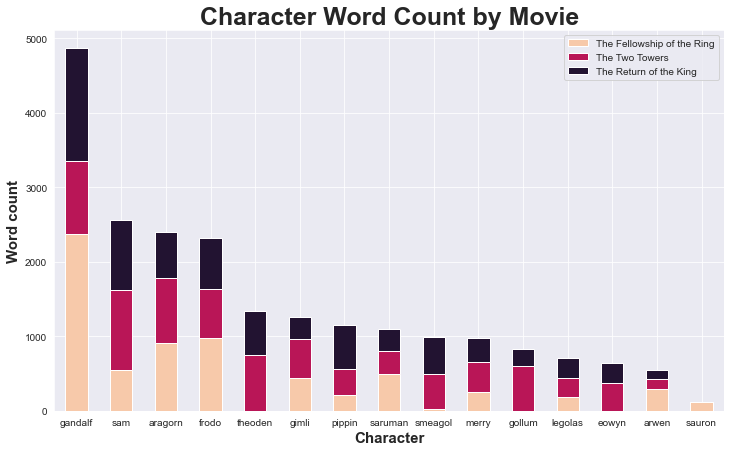

In [105]:
# create bar plot with seaborn
all_character_wc_df_sorted_cleaned = all_character_wc_df_sorted.drop('Total', axis=1)
sns.set_style('darkgrid')
barplt_wc_per_film = all_character_wc_df_sorted_cleaned.set_index('Character').plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("rocket_r", 10)), figsize=(12, 7))

barplt_wc_per_film.set_title("Character Word Count by Movie", fontsize=25, fontweight="bold")
barplt_wc_per_film.set_xlabel("Character", fontsize=15, fontweight="bold")
barplt_wc_per_film.set_ylabel("Word count", fontsize=15, fontweight="bold")
barplt_wc_per_film.set_xticklabels(barplt_wc_per_film.get_xticklabels(), rotation=0)

In [108]:
# save plot
# .figrue is needed here because the variable barplt_wc_per_filk is an axes subplot object not a figure object
# barplt_wc_per_film.figure.savefig("visualizations/barplots/barplt_wc_per_film.jpg", dpi=300)

[Text(0, 0, 'gandalf'),
 Text(1, 0, 'sam'),
 Text(2, 0, 'aragorn'),
 Text(3, 0, 'frodo'),
 Text(4, 0, 'theoden'),
 Text(5, 0, 'gimli'),
 Text(6, 0, 'pippin'),
 Text(7, 0, 'saruman'),
 Text(8, 0, 'smeagol'),
 Text(9, 0, 'merry'),
 Text(10, 0, 'gollum'),
 Text(11, 0, 'legolas'),
 Text(12, 0, 'eowyn'),
 Text(13, 0, 'arwen'),
 Text(14, 0, 'sauron')]

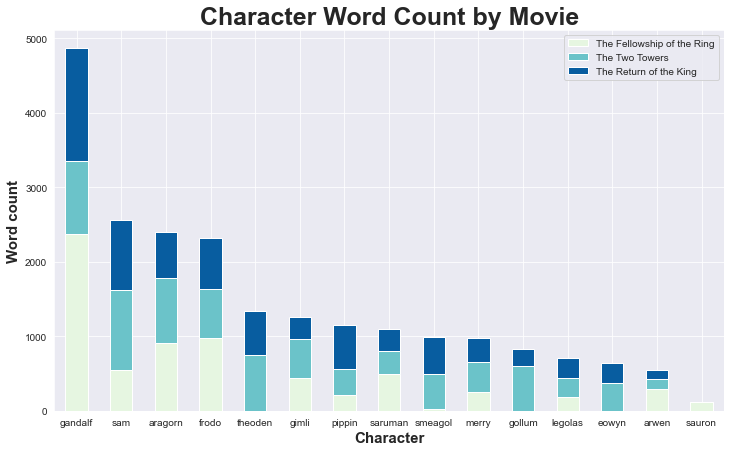

In [107]:
sns.set_style('darkgrid')
barplt_wc_per_film_blue = all_character_wc_df_sorted_cleaned.set_index('Character').plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), figsize=(12,7))

barplt_wc_per_film_blue.set_title("Character Word Count by Movie", fontsize=25, fontweight="bold")
barplt_wc_per_film_blue.set_xlabel("Character", fontsize=15, fontweight="bold")
barplt_wc_per_film_blue.set_ylabel("Word count", fontsize=15, fontweight="bold")
barplt_wc_per_film_blue.set_xticklabels(barplt_wc_per_film.get_xticklabels(), rotation=0)

In [109]:
# save figure
# barplt_wc_per_film_blue.figure.savefig("visualizations/barplots/barplt_wc_per_film_blue.jpg", dpi=300)

### Word Count (Without Separation by Film)

C:\Users\Marina\AppData\Local\Temp/ipykernel_10224/1435106879.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(plot.get_ymajorticklabels())


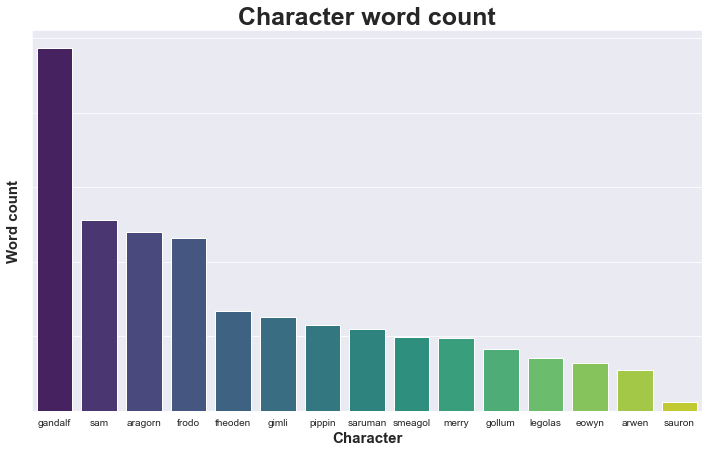

In [111]:
# create bar plot with seaborn
sns.set_style('darkgrid')
x = all_character_wc_df_sorted['Character']
y = all_character_wc_df_sorted['Total']
plt.subplots(figsize=(12,7))
# Overview color palettes: https://seaborn.pydata.org/tutorial/color_palettes.html
plot = sns.barplot(x=x, y=y, palette="viridis")
plot.set_title("Character word count", fontsize=25, fontweight="bold")
plot.set_xlabel("Character", fontsize=15, fontweight="bold")
plot.set_ylabel("Word count", fontsize=15, fontweight="bold")
plot.set_xticklabels(plot.get_xmajorticklabels())
plot.set_yticklabels(plot.get_ymajorticklabels())
plt.show()
# save bar plot file
barplot = plot.get_figure()
barplot.savefig("visualizations/barplots/character_word_count.jpg", dpi=300)

## Wordclouds and Word Frequencies<a class="anchor" id="wordclouds_frequency_tables"></a> 
→ [Helper Functions](#helper_functions)

### Frodo

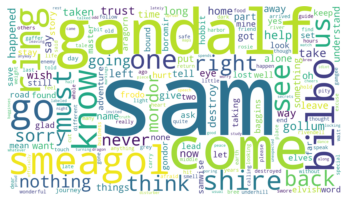

In [112]:
# generate standard wordcloud
wordcloud_frodo = make_wordcloud(frodo_all)

In [113]:
# save wordcloud file
#wordcloud_frodo.to_file("visualizations/wordclouds/wordcloud_frodo.jpg")

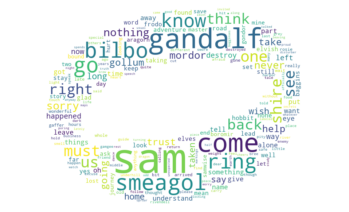

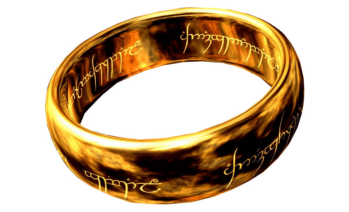

In [114]:
# generate ring wordcloud
ring_wordcloud_frodo = make_masked_wordcloud(frodo_all)

In [115]:
# save ring wordcloud file
# ring_wordcloud_frodo.to_file("visualizations/wordclouds/ring_wordcloud_frodo.jpg")

# save ring wordcloud file as svg
# wordcloud_svg = ring_wordcloud_frodo.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_frodo.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [116]:
# count word frequencies
word_frequency_frodo = get_word_frequency(frodo_all, 15)
word_frequency_frodo

Word  Frequency
0       sam         69
1   gandalf         21
2      come         19
3   smeagol         19
4     bilbo         18
5        go         18
6      ring         17
7      know         12
8     shire          9
9       one          9
10     must          9
11       us          9
12      see          8
13    right          8
14     back          8

In [117]:
# How many times does Frodo say "Sam"?
frodo_says_sam = word_freq(frodo_all, "sam")
frodo_says_sam

73

In [118]:
# How many times does Frodo say "Gandalf"?
frodo_says_sam = word_freq(frodo_all, "gandalf")
frodo_says_sam

21

### Gandalf

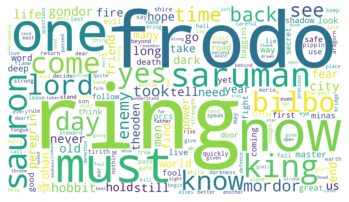

In [119]:
wordcloud_gandalf = make_wordcloud(gandalf_all)

In [120]:
# save wordcloud file
# wordcloud_gandalf.to_file("visualizations/wordclouds/wordcloud_gandalf.jpg")

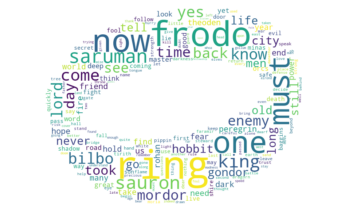

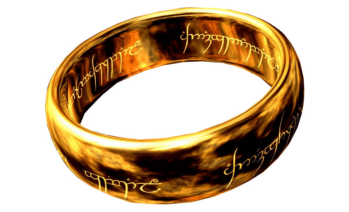

In [121]:
# generate ring wordcloud
ring_wordcloud_gandalf = make_masked_wordcloud(gandalf_all)

In [122]:
# save ring wordcloud file
# ring_wordcloud_gandalf.to_file("visualizations/wordclouds/ring_wordcloud_gandalf.jpg")

# save ring wordcloud file as svg
# wordcloud_svg = ring_wordcloud_gandalf.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_gandalf.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [123]:
# count word frequencies
word_frequency_gandalf = get_word_frequency(gandalf_all, 15)
word_frequency_gandalf

Word  Frequency
0      ring         39
1     frodo         32
2       now         28
3      must         23
4       one         23
5   saruman         21
6    sauron         20
7      king         16
8     bilbo         14
9      come         14
10      yes         14
11     lord         13
12     know         13
13     back         13
14   mordor         12

### Sam

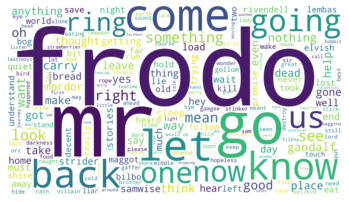

In [124]:
wordcloud_sam = make_wordcloud(sam_all)

In [125]:
# save wordcloud file
# wordcloud_sam.to_file("visualizations/wordclouds/wordcloud_sam.jpg")

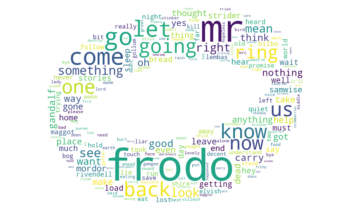

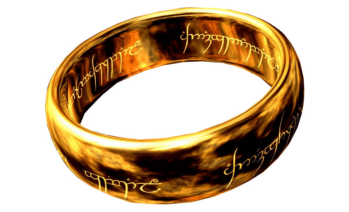

In [126]:
# generate ring wordcloud
ring_wordcloud_sam = make_masked_wordcloud(sam_all)

In [127]:
# save ring wordcloud file
# ring_wordcloud_sam.to_file("visualizations/wordclouds/ring_wordcloud_sam.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_sam.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_sam.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [128]:
# count word frequencies
word_frequency_sam = get_word_frequency(sam_all, 15)
word_frequency_sam

Word  Frequency
0       frodo         89
1          mr         68
2          go         18
3        come         17
4         let         14
5        back         12
6       going         12
7          us         12
8        know         11
9         now         11
10  something         10
11        one         10
12        see         10
13       look          9
14       ring          8

### Merry

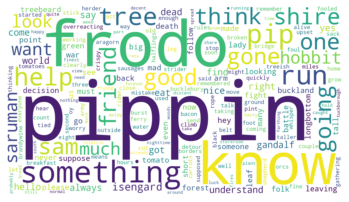

In [129]:
wordcloud_merry = make_wordcloud(merry_all)

In [130]:
# save wordcloud file
# wordcloud_merry.to_file("visualizations/wordclouds/wordcloud_merry.jpg")

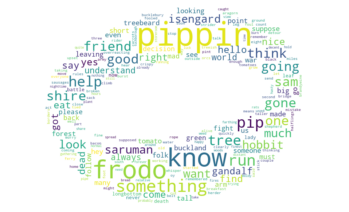

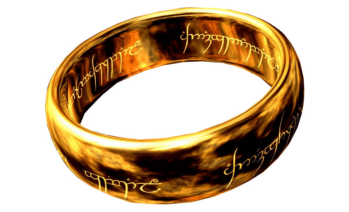

In [131]:
# generate ring wordcloud
ring_wordcloud_merry = make_masked_wordcloud(merry_all)

In [132]:
# save ring wordcloud file
# ring_wordcloud_merry.to_file("visualizations/wordclouds/ring_wordcloud_merry.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_merry.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_merry.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [133]:
# count word frequencies
word_frequency_merry = get_word_frequency(merry_all, 15)
word_frequency_merry

Word  Frequency
0      pippin         20
1       frodo         11
2        know          9
3   something          9
4         run          7
5         pip          7
6        help          6
7         one          5
8        good          5
9         sam          5
10       gone          5
11      going          5
12      think          4
13       want          4
14       look          4

### Pippin

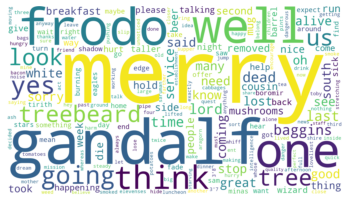

In [134]:
wordcloud_pippin = make_wordcloud(pippin_all)

In [135]:
# save wordcloud file
# wordcloud_pippin.to_file("visualizations/wordclouds/wordcloud_pippin.jpg")

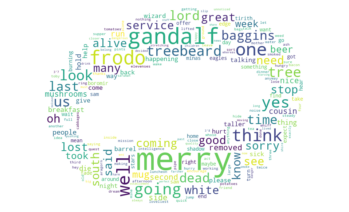

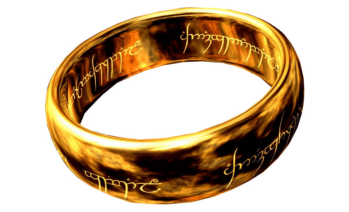

In [136]:
# generate ring wordcloud
ring_wordcloud_pippin = make_masked_wordcloud(pippin_all)

In [137]:
# save ring wordcloud file
# ring_wordcloud_pippin.to_file("visualizations/wordclouds/ring_wordcloud_pippin.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_pippin.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_pippin.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [138]:
# count word frequencies
word_frequency_pippin = get_word_frequency(pippin_all, 15)
word_frequency_pippin

Word  Frequency
0       merry         32
1     gandalf         12
2       frodo          9
3         one          8
4       think          7
5        well          7
6       going          6
7         yes          6
8   treebeard          5
9        look          5
10         us          5
11    baggins          4
12       last          4
13       tree          4
14       dead          4

### Aragorn

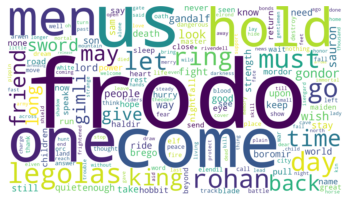

In [139]:
wordcloud_aragorn = make_wordcloud(aragorn_all)

In [140]:
# save wordcloud file
# wordcloud_aragorn.to_file("visualizations/wordclouds/wordcloud_aragorn.jpg")

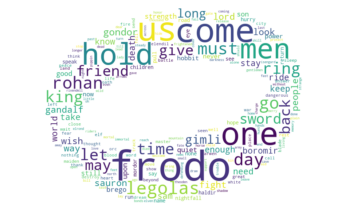

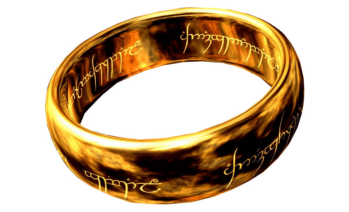

In [141]:
# generate ring wordcloud
ring_wordcloud_aragorn = make_masked_wordcloud(aragorn_all)

In [142]:
# save ring wordcloud file
# ring_wordcloud_aragorn.to_file("visualizations/wordclouds/ring_wordcloud_aragorn.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_aragorn.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_aragorn.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [143]:
# count word frequencies
word_frequency_aragorn = get_word_frequency(aragorn_all, 15)
word_frequency_aragorn

Word  Frequency
0     frodo         20
1        us         13
2       one         12
3      come         12
4      hold         11
5       men         10
6   legolas         10
7      must          9
8     rohan          9
9        go          9
10      let          8
11      day          8
12     ring          7
13      may          7
14     back          7

### Arwen

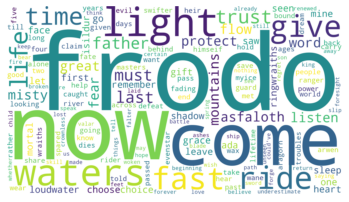

In [144]:
wordcloud_arwen = make_wordcloud(arwen_all)

In [145]:
# save wordcloud file
# wordcloud_arwen.to_file("visualizations/wordclouds/wordcloud_arwen.jpg")

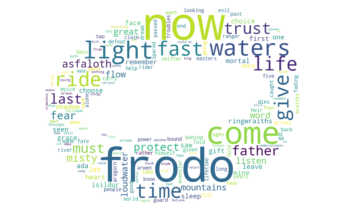

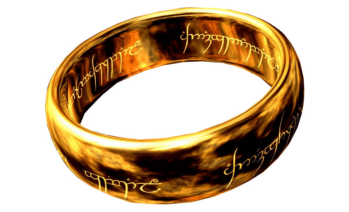

In [146]:
# generate ring wordcloud
ring_wordcloud_arwen = make_masked_wordcloud(arwen_all)

In [147]:
# save ring wordcloud file
# ring_wordcloud_arwen.to_file("visualizations/wordclouds/ring_wordcloud_arwen.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_arwen.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_arwen.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [148]:
# count word frequencies
word_frequency_arwen = get_word_frequency(arwen_all, 15)
word_frequency_arwen

Word  Frequency
0     frodo          6
1       now          6
2      come          4
3     light          4
4    waters          4
5      ride          3
6      fast          3
7      give          3
8      time          3
9      life          3
10    trust          3
11     last          2
12     must          2
13   father          2
14  protect          2

### Eowyn

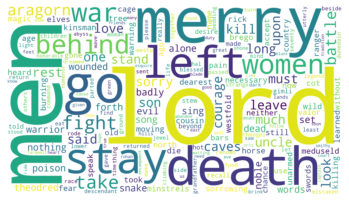

In [149]:
wordcloud_eowyn = make_wordcloud(eowyn_all)

In [150]:
# save wordcloud file
# wordcloud_eowyn.to_file("visualizations/wordclouds/wordcloud_eowyn.jpg")

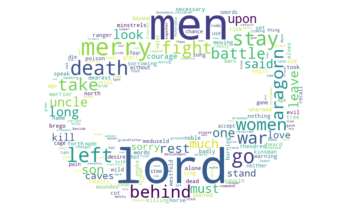

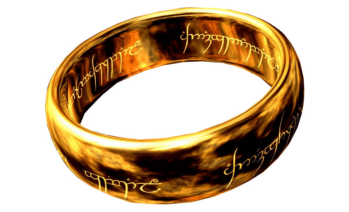

In [151]:
# generate ring wordcloud
ring_wordcloud_eowyn = make_masked_wordcloud(eowyn_all)

In [152]:
# save ring wordcloud file
# ring_wordcloud_eowyn.to_file("visualizations/wordclouds/ring_wordcloud_eowyn.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_eowyn.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_eowyn.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [153]:
# count word frequencies
word_frequency_eowyn = get_word_frequency(eowyn_all, 15)
word_frequency_eowyn

Word  Frequency
0      lord          7
1       men          6
2     merry          6
3        go          4
4     death          4
5      stay          4
6      left          4
7     women          3
8    behind          3
9       war          3
10    fight          3
11     take          3
12  aragorn          3
13   battle          3
14      son          2

### Legolas

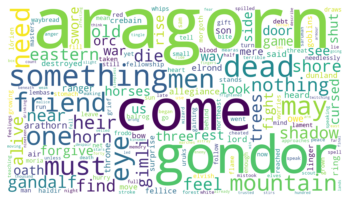

In [154]:
wordcloud_legolas = make_wordcloud(legolas_all)

In [155]:
# save wordcloud file
# wordcloud_legolas.to_file("visualizations/wordclouds/wordcloud_legolas.jpg")

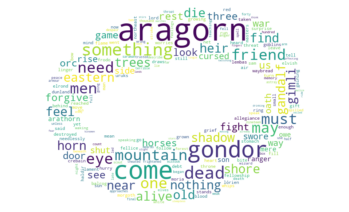

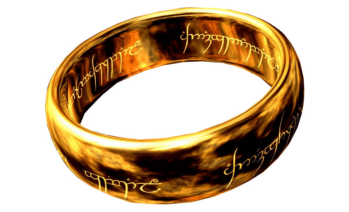

In [156]:
# generate ring wordcloud
ring_wordcloud_legolas = make_masked_wordcloud(legolas_all)

In [157]:
# save ring wordcloud file
# ring_wordcloud_legolas.to_file("visualizations/wordclouds/ring_wordcloud_legolas.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_legolas.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_legolas.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [158]:
# count word frequencies
word_frequency_legolas = get_word_frequency(legolas_all, 15)
word_frequency_legolas

Word  Frequency
0     aragorn          8
1        come          5
2      gondor          4
3   something          4
4        dead          4
5        must          3
6         one          3
7         may          3
8        need          3
9         men          3
10       heir          2
11    nothing          2
12    gandalf          2
13     shadow          2
14       near          2

### Gimli

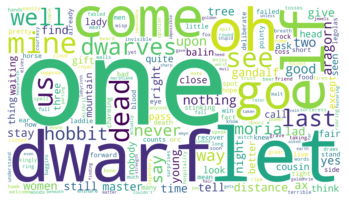

In [159]:
wordcloud_gimli = make_wordcloud(gimli_all)

In [160]:
# save wordcloud file
# wordcloud_gimli.to_file("visualizations/wordclouds/wordcloud_gimli.jpg")

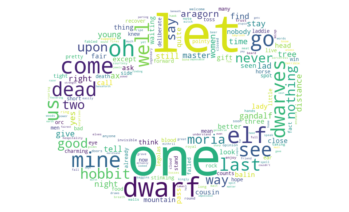

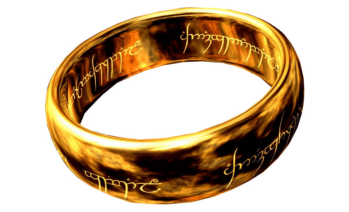

In [161]:
# generate ring wordcloud
ring_wordcloud_gimli = make_masked_wordcloud(gimli_all)

In [162]:
# save ring wordcloud file
# ring_wordcloud_gimli.to_file("visualizations/wordclouds/ring_wordcloud_gimli.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_gimli.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_gimli.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [163]:
# count word frequencies
word_frequency_gimli = get_word_frequency(gimli_all, 15)
word_frequency_gimli

Word  Frequency
0       one         11
1       let         11
2     dwarf         10
3        oh          7
4      come          7
5       elf          6
6        go          6
7      dead          5
8       see          5
9        us          5
10  dwarves          5
11     well          5
12    never          4
13      way          4
14    moria          4

### Theoden

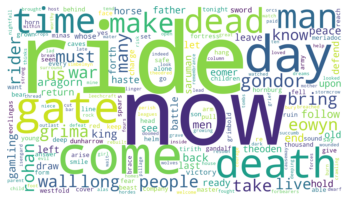

In [164]:
wordcloud_theoden = make_wordcloud(theoden_all)

In [165]:
# save wordcloud file
# wordcloud_theoden.to_file("visualizations/wordclouds/wordcloud_theoden.jpg")

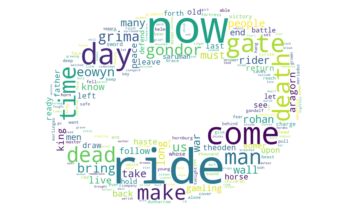

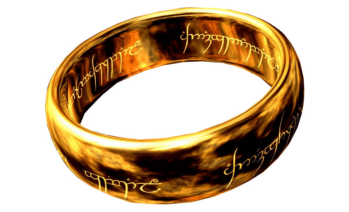

In [166]:
# generate ring wordcloud
ring_wordcloud_theoden = make_masked_wordcloud(theoden_all)

In [167]:
# save ring wordcloud file
# ring_wordcloud_theoden.to_file("visualizations/wordclouds/ring_wordcloud_theoden.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_theoden.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_theoden.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [168]:
# count word frequencies
word_frequency_theoden = get_word_frequency(theoden_all, 15)
word_frequency_theoden

Word  Frequency
0     ride         10
1      now          9
2     come          9
3    death          6
4     time          6
5     dead          6
6      man          6
7     make          6
8     gate          6
9   gondor          6
10   grima          5
11   eowyn          5
12    days          5
13      us          5
14   bring          5

### Saruman

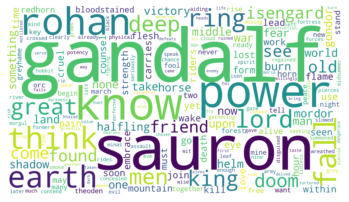

In [169]:
wordcloud_saruman = make_wordcloud(saruman_all)

In [170]:
# save wordcloud file
# wordcloud_saruman.to_file("visualizations/wordclouds/wordcloud_saruman.jpg")

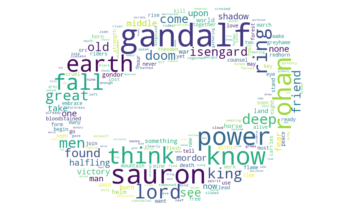

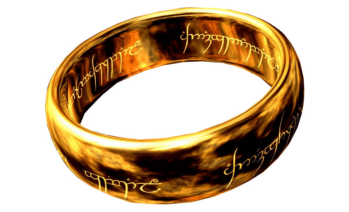

In [171]:
# generate ring wordcloud
ring_wordcloud_saruman = make_masked_wordcloud(saruman_all)

In [172]:
# save ring wordcloud file
# ring_wordcloud_saruman.to_file("visualizations/wordclouds/ring_wordcloud_saruman.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_saruman.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_saruman.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [173]:
# count word frequencies
word_frequency_saruman = get_word_frequency(saruman_all, 15)
word_frequency_saruman

Word  Frequency
0    gandalf         10
1     sauron          7
2       know          6
3      rohan          6
4      power          5
5       fall          5
6       ring          4
7      think          4
8       lord          4
9      great          4
10      deep          4
11      doom          3
12  isengard          3
13      come          3
14       old          3

### Gollum

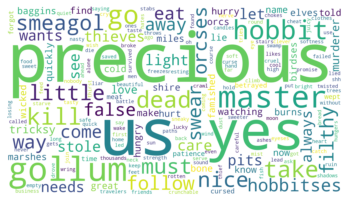

In [174]:
wordcloud_gollum = make_wordcloud(gollum_all)

In [175]:
# save wordcloud file
# wordcloud_gollum.to_file("visualizations/wordclouds/wordcloud_gollum.jpg")

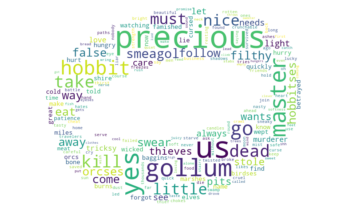

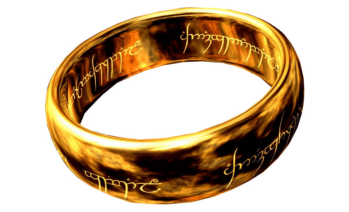

In [176]:
# generate ring wordcloud
ring_wordcloud_gollum = make_masked_wordcloud(gollum_all)

In [177]:
# save ring wordcloud file
# ring_wordcloud_gollum.to_file("visualizations/wordclouds/ring_wordcloud_gollum.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_gollum.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_gollum.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [178]:
# count word frequencies
word_frequency_gollum = get_word_frequency(gollum_all, 15)
word_frequency_gollum

Word  Frequency
0   precious         23
1         us         21
2        yes         14
3     gollum         13
4     master         11
5         go          8
6       kill          6
7       dead          6
8     little          5
9       nice          5
10      must          5
11   smeagol          5
12    filthy          4
13      take          4
14    orcses          4

### Smeagol

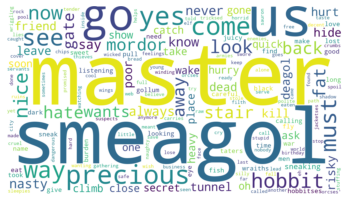

In [179]:
wordcloud_smeagol = make_wordcloud(smeagol_all)

In [180]:
# save wordcloud file
# wordcloud_smeagol.to_file("visualizations/wordclouds/wordcloud_smeagol.jpg")

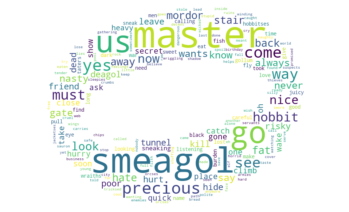

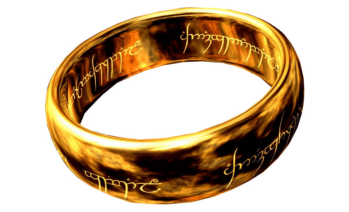

In [181]:
# generate ring wordcloud
ring_wordcloud_smeagol = make_masked_wordcloud(smeagol_all)

In [182]:
# save ring wordcloud file
# ring_wordcloud_smeagol.to_file("visualizations/wordclouds/ring_wordcloud_smeagol.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_smeagol.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_smeagol.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [183]:
# count word frequencies
word_frequency_smeagol = get_word_frequency(smeagol_all, 15)
word_frequency_smeagol

Word  Frequency
0     master         27
1    smeagol         23
2         go         17
3         us         16
4   precious         15
5        yes         15
6       come         14
7        see         11
8       must         11
9        way         10
10       now          8
11      nice          8
12    mordor          6
13      back          6
14      away          6

### Sauron

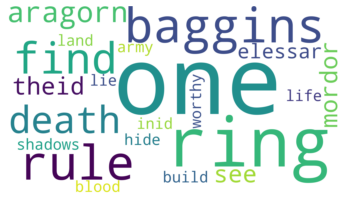

In [184]:
wordcloud_sauron = make_wordcloud(sauron_all)

In [185]:
# save wordcloud file
# wordcloud_sauron.to_file("visualizations/wordclouds/wordcloud_sauron.jpg")

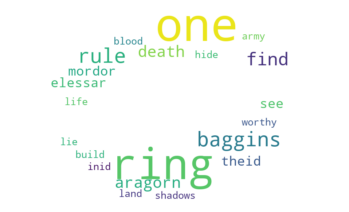

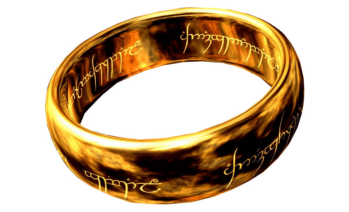

In [186]:
# generate ring wordcloud
ring_wordcloud_sauron = make_masked_wordcloud(sauron_all)

In [187]:
# save ring wordcloud file
# ring_wordcloud_sauron.to_file("visualizations/wordclouds/ring_wordcloud_sauron.jpg")

# save ring wordcloud file
# wordcloud_svg = ring_wordcloud_sauron.to_svg(embed_font=True)
# f = open("visualizations/wordclouds/ring_wordcloud_sauron.svg","w+")
# f.write(wordcloud_svg)
# f.close()

In [188]:
# count word frequencies
word_frequency_sauron = get_word_frequency(sauron_all, 15)
word_frequency_sauron

Word  Frequency
0       one          9
1      ring          9
2   baggins          5
3      rule          5
4      find          4
5     death          3
6   aragorn          3
7       see          2
8    mordor          2
9   elessar          2
10     hide          1
11     life          1
12    theid          1
13    build          1
14     army          1

## Character Mentions <a class="anchor" id="character_mentions"></a>

In [189]:
# concat all dialog and stage directions data
all_movie_data = f'{dialog_text_all_films}{stage_directions_all_films}'
all_movie_data

' the world is changed. i feel it in the water. i feel it in the earth. i smell it in the air. much that once was  is lost. for none now live who remember it. it began with the forging of the great rings. three were given to the elves: immortal, wisest and fairest of all beings. seven to the dwarf-lords: great miners and craftsmen of the mountain halls. and nine  nine rings were gifted to the race of men  who, above all else, desire power. for within these rings was bound the strength and will to govern each race. but they were all of them deceived. for another ring was made. in the land of mordor, in the fires of mount doom  the dark lord sauron forged in secret a master ring  to control all others. and into this ring he poured his cruelty, his malice  and his will to dominate all life. one ring to rule them all. one by one  the free lands of middle-earth fell to the power of the ring. but there were some who resisted. a last alliance of men and elves marched against the armies of mor

In [190]:
# mentions across all movie data (dialog and regie)
character_mentions_df = makeMentionsDf(all_movie_data)
character_mentions_df.rename(columns = {'Mentions':'Mentions_Total'}, inplace = True)
character_mentions_df

Character  Mentions_Total
0      frodo             802
1        sam             439
2    gandalf             407
3    aragorn             322
4     pippin             251
5      merry             183
6     gollum             151
7      gimli             129
8    theoden             125
9    legolas             120
10   saruman              99
11     eowyn              88
12   smeagol              86
13    sauron              73
14     arwen              71

In [191]:
# mentions in dialog data
character_mentions_df_dialog_only = makeMentionsDf(dialog_text_all_films)
character_mentions_df_dialog_only.rename(columns = {'Mentions':'Mentions_Dialog'}, inplace = True)
character_mentions_df_dialog_only

Character  Mentions_Dialog
0      frodo              205
1        sam              101
2    gandalf               98
3     sauron               52
4    smeagol               50
5    saruman               48
6      merry               47
7    aragorn               47
8     gollum               32
9     pippin               31
10   theoden               29
11     gimli               17
12   legolas               15
13     arwen               13
14     eowyn                8

In [192]:
# mentions across stage directions
character_mentions_df_regie_only = makeMentionsDf(stage_directions_all_films)
character_mentions_df_regie_only.rename(columns = {'Mentions':'Mentions_Regie'}, inplace = True)                                               
character_mentions_df_regie_only                

Character  Mentions_Regie
0      frodo             597
1        sam             338
2    gandalf             309
3    aragorn             275
4     pippin             220
5      merry             136
6     gollum             119
7      gimli             112
8    legolas             105
9    theoden              96
10     eowyn              80
11     arwen              58
12   saruman              51
13   smeagol              36
14    sauron              21

In [193]:
# merge mentions data frames
df_all_character_mentions_complete = pd.merge(character_mentions_df, 
                                              character_mentions_df_dialog_only, 
                                                on=['Character'])
df_all_character_mentions_complete = pd.merge(df_all_character_mentions_complete, 
                                              character_mentions_df_regie_only, 
                                                on=['Character'])
df_all_character_mentions_complete

Character  Mentions_Total  Mentions_Dialog  Mentions_Regie
0      frodo             802              205             597
1        sam             439              101             338
2    gandalf             407               98             309
3    aragorn             322               47             275
4     pippin             251               31             220
5      merry             183               47             136
6     gollum             151               32             119
7      gimli             129               17             112
8    theoden             125               29              96
9    legolas             120               15             105
10   saruman              99               48              51
11     eowyn              88                8              80
12   smeagol              86               50              36
13    sauron              73               52              21
14     arwen              71               13              58

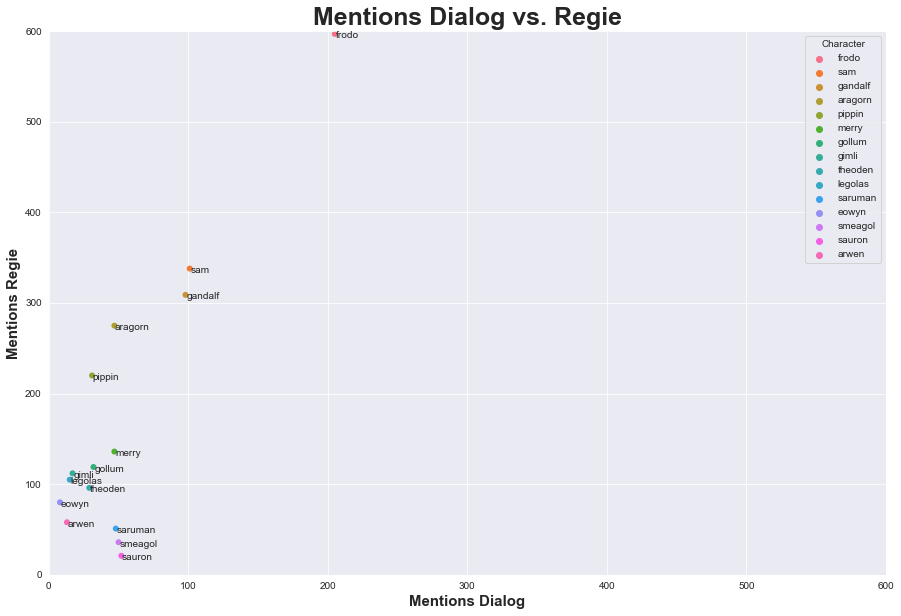

In [223]:
# scatterplot
plt.figure(figsize=(20,10))
plt.xlim(0, 600)
plt.ylim(0, 600)
#plt.gca().set_aspect('equal')
scatter_mentions_dialog_regie = sns.scatterplot(x="Mentions_Dialog", y="Mentions_Regie",
                hue="Character",
                sizes=(12, 10), linewidth=0,
                data=df_all_character_mentions_complete)
scatter_mentions_dialog_regie.set_title("Mentions Dialog vs. Regie", fontsize=25, fontweight="bold")
scatter_mentions_dialog_regie.set_xlabel("Mentions Dialog", fontsize=15, fontweight="bold")
scatter_mentions_dialog_regie.set_ylabel("Mentions Regie", fontsize=15, fontweight="bold")
# label the dots
for name in characters_list:
    plt.text(x=df_all_character_mentions_complete.Mentions_Dialog[df_all_character_mentions_complete.Character==name] + 0.5, 
         y=df_all_character_mentions_complete.Mentions_Regie[df_all_character_mentions_complete.Character==name] - 5,
         s=name)

In [222]:
# save figure
# scatter_mentions_dialog_regie.figure.savefig("visualizations/scatter_character_mentions_new.jpg", dpi=300)

### Bar Plot for Character Mentions

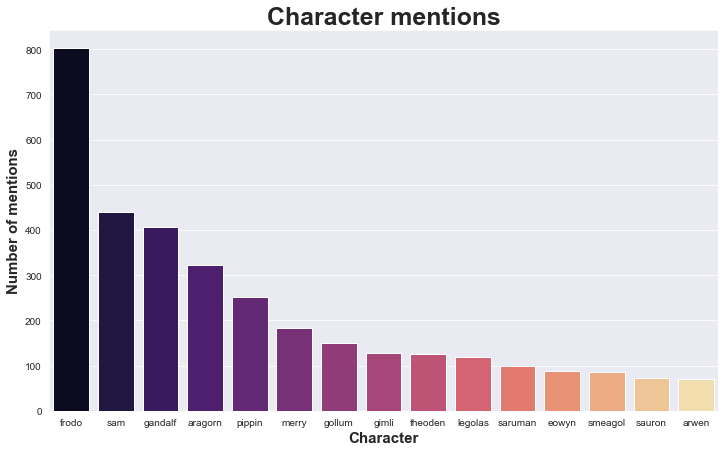

In [196]:
# create bar plot with seaborn
sns.set_style('darkgrid')
x = character_mentions_df['Character']
y = character_mentions_df['Mentions_Total']
plt.subplots(figsize=(12,7))
# Overview color palettes: https://seaborn.pydata.org/tutorial/color_palettes.html. Magma looks nice
plot = sns.barplot(x=x, y=y, palette="magma")
plot.set_title("Character mentions", fontsize=25, fontweight="bold")
plot.set_xlabel("Character", fontsize=15, fontweight="bold")
plot.set_ylabel("Number of mentions", fontsize=15, fontweight="bold")
plt.show()
# save bar plot file
barplot = plot.get_figure()
# barplot.savefig("visualizations/barplots/character_mentions.jpg", dpi=300)

## Character Mentions vs. Character Wordcount

### Scatterplot: Mentions vs. Wordcount

In [197]:
# merge df for mentions and df for wc
df_all_character_wc_mentions = pd.merge(all_character_wc_df_sorted, character_mentions_df, on=['Character'])
# rename columns
df_all_character_wc_mentions.rename(columns = {'Total':'Word_Count_Total'}, inplace = True)
df_all_character_wc_mentions.rename(columns = {'Mentions':'Mentions_Total'}, inplace = True)

df_all_character_wc_mentions

Character  The Fellowship of the Ring  The Two Towers  \
0    gandalf                        2366             989   
1        sam                         554            1064   
2    aragorn                         906             876   
3      frodo                         972             664   
4    theoden                           0             752   
5      gimli                         434             524   
6     pippin                         212             351   
7    saruman                         493             310   
8    smeagol                          19             469   
9      merry                         251             404   
10    gollum                           4             595   
11   legolas                         190             249   
12     eowyn                           0             370   
13     arwen                         289             139   
14    sauron                         114               1   

    The Return of the King  Word_Count_Total  Mentions_Total  
0                     1507              4862             407  
1                      939              2557             439  
2                      611              2393             322  
3                      684              2320             802  
4                      582              1334             125  
5                      300              1258             129  
6                      591              1154             251  
7                      301              1104              99  
8                      505               993              86  
9                      325               980             183  
10                     228               827             151  
11                     269               708             120  
12                     270               640              88  
13                     123               551              71  
14                       5               120              73

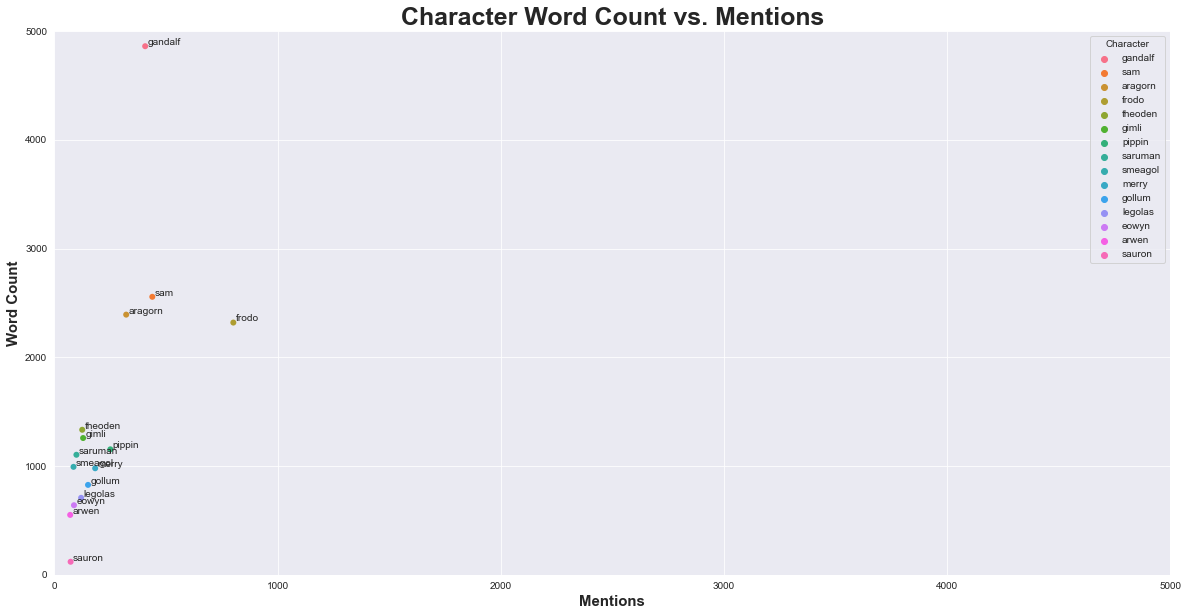

In [224]:
# scatterplot
plt.figure(figsize=(20,10))
plt.xlim(0, 5000)
plt.ylim(0, 5000)
#plt.gca().set_aspect('equal')
scatter_wc_mentions = sns.scatterplot(x="Mentions_Total", y="Word_Count_Total",
                hue="Character",
                sizes=(12, 10), linewidth=0,
                data=df_all_character_wc_mentions)
scatter_wc_mentions.set_title("Character Word Count vs. Mentions", fontsize=25, fontweight="bold")
scatter_wc_mentions.set_xlabel("Mentions", fontsize=15, fontweight="bold")
scatter_wc_mentions.set_ylabel("Word Count", fontsize=15, fontweight="bold")
# label the dots
for name in characters_list:
    plt.text(x=df_all_character_wc_mentions.Mentions_Total[df_all_character_wc_mentions.Character==name] + 10, 
         y=df_all_character_wc_mentions.Word_Count_Total[df_all_character_wc_mentions.Character==name] +10,
         s=name)

In [199]:
# save figure
# scatter_wc_mentions.figure.savefig("visualizations/scatter_character_mentions_wc.jpg", dpi=300)

### Save Dialog Text Files for Main Characters

In [200]:
# save frodo, gandalf, aragorn, gollum/smeagol, sam to file            
saveCharacterDataToFile(frodo_all, "frodo")
saveCharacterDataToFile(gandalf_all, "gandalf")
saveCharacterDataToFile(sam_all, "sam")
saveCharacterDataToFile(aragorn_all, "aragorn")
saveCharacterDataToFile(gollum_smeagol_all, "gollum_smeagol")

File frodo.txt saved.
File gandalf.txt saved.
File sam.txt saved.
File aragorn.txt saved.
File gollum_smeagol.txt saved.
